<a href="https://colab.research.google.com/github/rusetskiy1974/Data-Sciens/blob/main/HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.fft import fft
import pywt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc





In [26]:
import requests
from pathlib import Path
from zipfile import ZipFile

# Константи
SAVED_DATAFRAME_BASE = Path("/content/")
URL = "https://drive.usercontent.google.com/download?id=1nzrtQpfaHL0OgJ_eXzA7VuEj7XotrSWO&export=download&authuser=0"
OUTPUT = Path("/content/homework.zip")
CSV_DATA_PATH  = Path("/content/data")

# Завантаження файлу з URL з перевіркою
response = requests.get(URL)
if response.status_code == 200:
    with open(OUTPUT, "wb") as file:
        file.write(response.content)
        print(f"Файл завантажено за адресою: {OUTPUT}")
else:
    print(f"Помилка завантаження файлу. Статус код: {response.status_code}")

# Перевірка чи файл дійсно є ZIP-файлом
try:
    with ZipFile(OUTPUT, 'r') as zip_ref:
        zip_ref.extractall(SAVED_DATAFRAME_BASE)
        print(f"Файл розпаковано до: {SAVED_DATAFRAME_BASE}")
except zipfile.BadZipFile:
    print("Помилка: завантажений файл не є ZIP-файлом.")

# Перевірка вмісту папки CSV_DATA_PATH
for path in CSV_DATA_PATH.iterdir():
    print(path)

Файл завантажено за адресою: /content/homework.zip
Файл розпаковано до: /content
/content/data/running
/content/data/walking
/content/data/stairs
/content/data/idle


Функція для обробки файлів і витягування характеристик

In [27]:
# Шлях до кореневої папки з підпапками класів
#CSV_DATA_PATH = Path("/content/data")

# Завантаження даних з підпапок
def load_data(root_path):
    data = []
    labels = []
    for class_dir in root_path.iterdir():
        if class_dir.is_dir():
            label = class_dir.name.strip()  # Назва підпапки є міткою класу
            for file_path in class_dir.glob("*.csv"):
                df = pd.read_csv(file_path)
                # df = flatten_frame(df)
                df['label'] = label
                data.append(df)
    return pd.concat(data, ignore_index=True)



In [28]:
# Завантажуємо дані
raw_data = load_data(CSV_DATA_PATH)


Наш датасет з 'сирими' даними

In [29]:
print(f"Завантажені дані: {raw_data.shape}")
print(raw_data.sample(10))


Завантажені дані: (193860, 4)
        accelerometer_X  accelerometer_Y  accelerometer_Z    label
10345         14.566323        29.419950        -1.192312  running
42464         -1.316811         0.847547        -1.805228  running
24587         21.562180         1.106121         0.392649  running
6964          18.114530        23.913286        13.838486  running
22601         21.035456        27.844566         7.254431  running
113300        -1.900996        -2.772485        -1.972822  walking
104837         2.667141         1.833959        -2.303222  walking
155387        -4.539406       -10.769119       -11.645397  walking
185821         0.292093        -0.014365         9.753978     idle
55507         11.956643         0.311246         4.625598  running


In [30]:
# Підрахунок кількості зразків для кожного класу
class_distribution = raw_data['label'].value_counts().reset_index()
class_distribution.columns = ['class', 'count']

# Виведення даних про розподіл класів
print(class_distribution)

     class   count
0  running  102240
1  walking   55500
2     idle   31170
3   stairs    4950


Видно незбаланосваність класів. Незбалансованість класів є досить поширеною проблемою в задачах класифікації, коли один клас має значно більше прикладів, ніж інший. Це може призвести до того, що модель буде схильна приймати рішення на користь більш представлених класів і ігнорувати менш представлені. Багато класифікаторів мають параметр class_weight, який дозволяє задати вагу для кожного класу. Це дозволяє моделі приділити більше уваги менш представленим класам під час навчання.

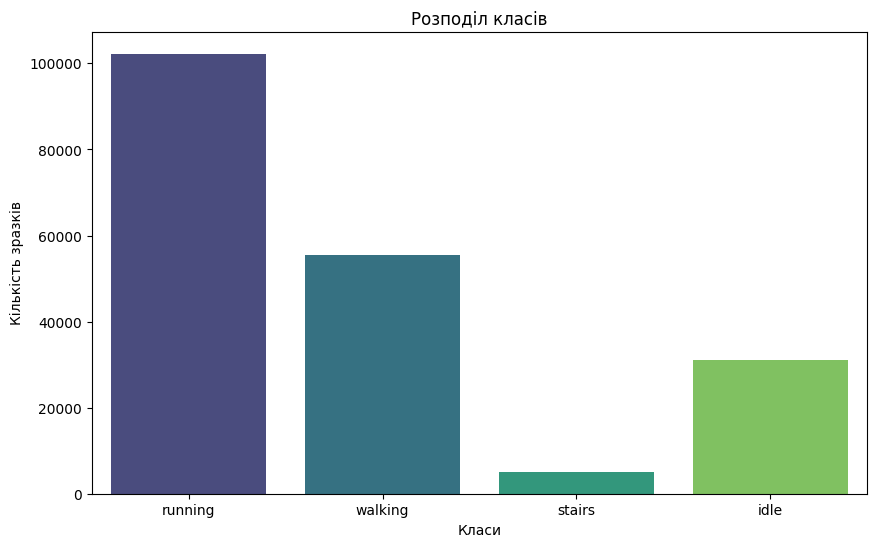

In [31]:
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=raw_data, hue='label', palette='viridis', dodge=False, legend=False)
plt.title('Розподіл класів')
plt.xlabel('Класи')
plt.ylabel('Кількість зразків')
plt.xticks(rotation=0)
plt.legend([],[], frameon=False)
plt.show()

Візуалізація confusion_matrix. Відображає кількість правильних та неправильних передбачень по кожному класу.

In [32]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

SVM Accuracy: 0.7180192572214581
Random Forest Accuracy: 0.938101788170564

SVM Classification Report:
               precision    recall  f1-score   support

        idle       0.75      0.99      0.85       468
     running       0.98      0.68      0.81      1546
      stairs       0.07      0.62      0.13        69
     walking       0.84      0.64      0.72       825

    accuracy                           0.72      2908
   macro avg       0.66      0.73      0.63      2908
weighted avg       0.88      0.72      0.77      2908

Random Forest Classification Report:
               precision    recall  f1-score   support

        idle       0.99      0.99      0.99       468
     running       0.95      0.95      0.95      1546
      stairs       0.90      0.41      0.56        69
     walking       0.89      0.92      0.90       825

    accuracy                           0.94      2908
   macro avg       0.93      0.82      0.85      2908
weighted avg       0.94      0.94      0.94

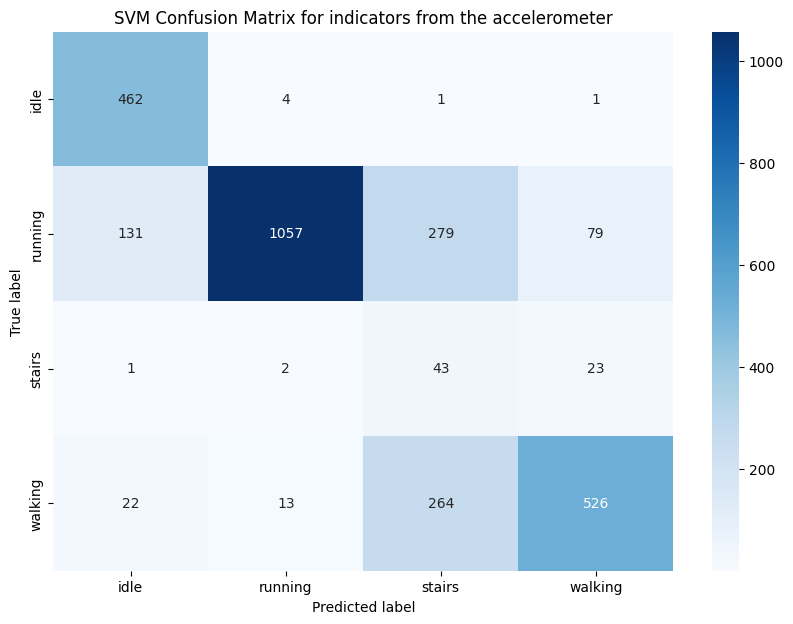

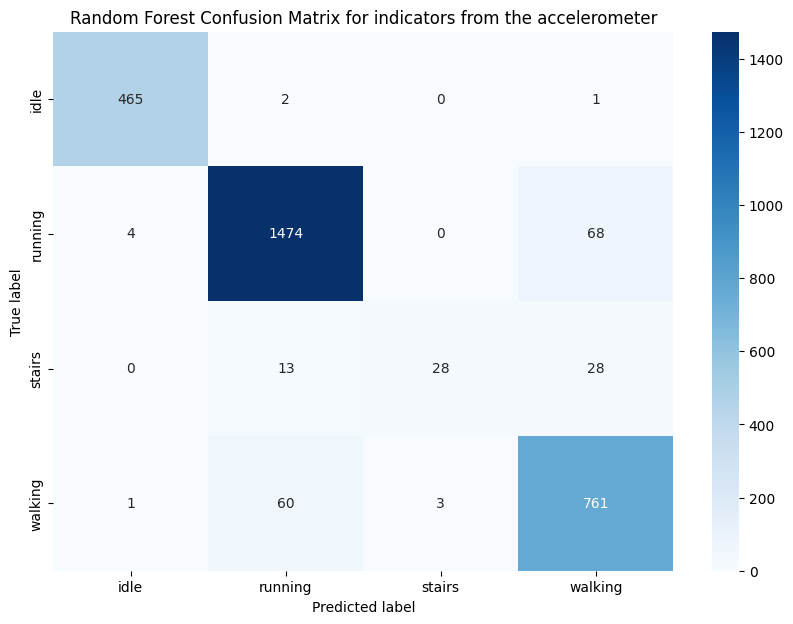

In [33]:

# Використання меншої підмножини даних для швидкого прототипування
raw_data_sample = raw_data.sample(frac=0.05, random_state=42)

# Розділення ознак та міток
X = raw_data_sample.drop(columns=['label'])
y = raw_data_sample['label']

# Розділення даних на тренувальний та тестовий набори
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Модель SVM
svm_model = SVC(kernel='linear', class_weight='balanced')
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

# Модель Випадковий ліс
rf_model = RandomForestClassifier(n_estimators=100,class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Оцінка моделей
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))

print("\nSVM Classification Report:\n", classification_report(y_test, y_pred_svm, zero_division=0))
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf, zero_division=0))
# Confusion Matrix

cm_svm = confusion_matrix(y_test, y_pred_svm)
cm_rf = confusion_matrix(y_test, y_pred_rf)

plot_confusion_matrix(cm_svm, classes=np.unique(y), title=f'SVM Confusion Matrix for indicators from the accelerometer')
plot_confusion_matrix(cm_rf, classes=np.unique(y), title=f'Random Forest Confusion Matrix for indicators from the accelerometer')


Розуміючи, що значення акселерометра можуть бути від'ємними, ми повинні скоригувати обчислення ентропії, щоб уникнути помилок. Одним з підходів є зсув значень сигналу так, щоб вони були невід'ємними перед обчисленням ентропії.

In [37]:
def compute_entropy(signal):
    epsilon = 1e-9
    signal_shifted = signal - signal.min() + epsilon  # Зсув значень сигналу
    probability_distribution = signal_shifted / np.sum(signal_shifted)
    entropy = -np.sum(probability_distribution * np.log2(probability_distribution))
    return entropy

Функція витягування часових ознак

In [38]:
def extract_time_domain_features(df, window_size=50, step_size=25):
    features = []

    for start in range(0, len(df) - window_size + 1, step_size):
        end = start + window_size
        window = df.iloc[start:end]

        feature_dict = {}
        for axis in ['accelerometer_X', 'accelerometer_Y', 'accelerometer_Z']:
            feature_dict[f'{axis}_mean'] = window[axis].mean()
            feature_dict[f'{axis}_var'] = window[axis].var()
            feature_dict[f'{axis}_std'] = window[axis].std()
            feature_dict[f'{axis}_median'] = window[axis].median()
            feature_dict[f'{axis}_min'] = window[axis].min()
            feature_dict[f'{axis}_max'] = window[axis].max()
            feature_dict[f'{axis}_range'] = window[axis].max() - window[axis].min()
            feature_dict[f'{axis}_rms'] = np.sqrt((window[axis]**2).mean())
            feature_dict[f'{axis}_sma'] = window[axis].abs().sum() / window_size
            feature_dict[f'{axis}_index_min'] = window[axis].idxmin()
            feature_dict[f'{axis}_index_max'] = window[axis].idxmax()
            feature_dict[f'{axis}_power'] = (window[axis]**2).sum()
            feature_dict[f'{axis}_energy'] = (window[axis]**2).mean()

            feature_dict[f'{axis}_entropy'] = compute_entropy(window[axis])

            feature_dict[f'{axis}_skewness'] = window[axis].skew()
            feature_dict[f'{axis}_kurtosis'] = window[axis].kurtosis()
            feature_dict[f'{axis}_iqr'] = window[axis].quantile(0.75) - window[axis].quantile(0.25)
            # feature_dict[f'{axis}_mad'] = window[axis].mad()


        # Label
        feature_dict['label'] = window['label'].mode()[0]

        features.append(feature_dict)

    return pd.DataFrame(features)


# Витягування часових ознак
time_features = extract_time_domain_features(raw_data)
# df_t: дані з часовими ознаками
df_t = time_features
print(f"df_t shape: {df_t.shape}")

df_t shape: (7753, 52)


SVM Accuracy: 0.9995700773860705
Random Forest Accuracy: 0.9995700773860705

SVM Classification Report:
               precision    recall  f1-score   support

        idle       1.00      1.00      1.00       360
     running       1.00      1.00      1.00      1248
      stairs       1.00      0.98      0.99        66
     walking       1.00      1.00      1.00       652

    accuracy                           1.00      2326
   macro avg       1.00      1.00      1.00      2326
weighted avg       1.00      1.00      1.00      2326

Random Forest Classification Report:
               precision    recall  f1-score   support

        idle       1.00      1.00      1.00       360
     running       1.00      1.00      1.00      1248
      stairs       0.99      1.00      0.99        66
     walking       1.00      1.00      1.00       652

    accuracy                           1.00      2326
   macro avg       1.00      1.00      1.00      2326
weighted avg       1.00      1.00      1.0

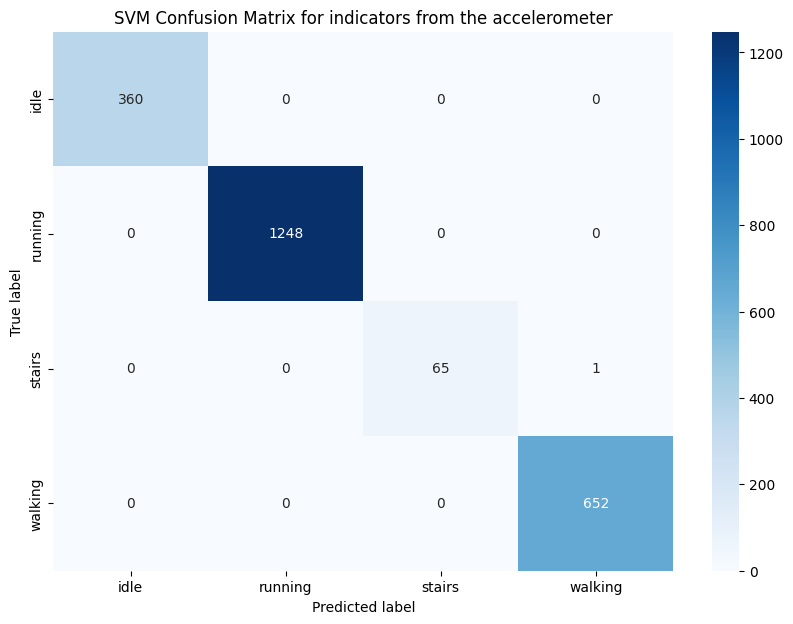

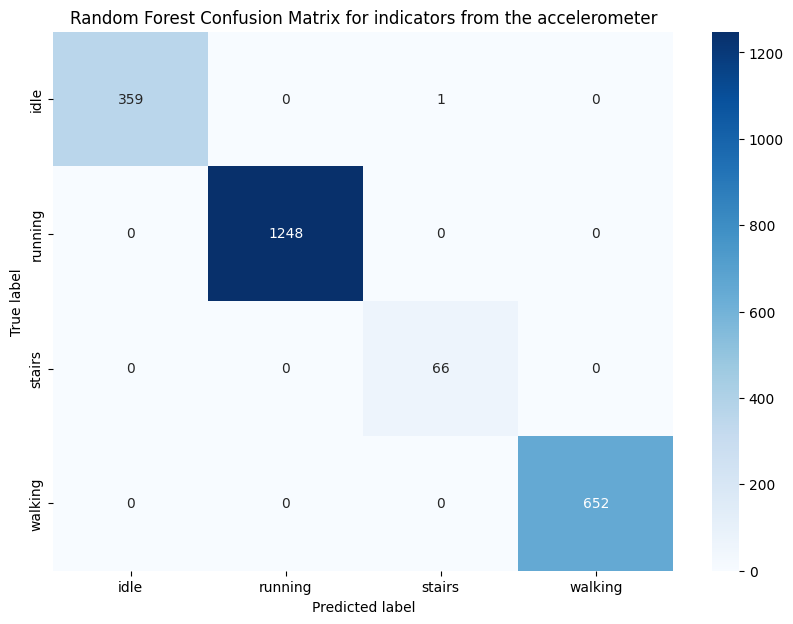

In [39]:
# Розділення ознак та міток
X = time_features.drop(columns=['label'])
y = time_features['label']

# Розділення даних на тренувальний та тестовий набори
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Модель SVM
svm_model = SVC(kernel='linear', class_weight='balanced')
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

# Модель Випадковий ліс
rf_model = RandomForestClassifier(n_estimators=100, n_jobs=-1, class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Оцінка моделей
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))

print("\nSVM Classification Report:\n", classification_report(y_test, y_pred_svm))
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))

# Confusion Matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
cm_rf = confusion_matrix(y_test, y_pred_rf)
plot_confusion_matrix(cm_svm, classes=np.unique(y), title=f'SVM Confusion Matrix for indicators from the accelerometer')
plot_confusion_matrix(cm_rf, classes=np.unique(y), title=f'Random Forest Confusion Matrix for indicators from the accelerometer')


Побудова ROC кривої (Receiver Operating Characteristic) — це інструмент для оцінки ефективності класифікаційної моделі, який використовується для бінарних і багатокласових задач. ROC-крива показує здатність моделі відокремлювати позитивні та негативні приклади при різних порогах класифікації.

In [40]:
def plot_multiclass_roc(y_test, y_pred_prob, n_classes, title):
    # Binarize the output
    y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_prob.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"], color='darkorange', lw=2,
             label=f'micro-average ROC curve (area = {roc_auc["micro"]:.2f})')
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=2,
                 label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

Функція plot_multiclass_precision_recall показує Precision-Recall криві для кожного класу окремо, а також мікросередню Precision-Recall криву для всіх класів. Це дозволяє візуалізувати, як добре модель розрізняє між різними класами, і оцінити продуктивність моделі для кожного класу. Пояснення до графіка Precision-Recall:
    Precision (точність): Це частка правильних позитивних передбачень серед всіх позитивних передбачень. Визначає, наскільки надійні передбачення моделі щодо конкретного класу.
    Recall (повнота): Це частка правильних позитивних передбачень серед всіх фактичних позитивних зразків. Визначає, наскільки добре модель знаходить всі зразки конкретного класу.
    Precision-Recall крива: Це графік, який показує взаємозв'язок між Precision та Recall для кожного класу при різних порогах передбачення. Крива допомагає визначити баланс між Precision та Recall для різних класів.
    Мікросередня Precision-Recall крива: Це середня крива, яка враховує всі зразки та класи. Вона допомагає оцінити загальну продуктивність моделі.

In [41]:
def plot_multiclass_precision_recall(y_test, y_pred_prob, n_classes, title):
    # Binarize the output
    y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

    precision = dict()
    recall = dict()
    average_precision = dict()

    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_pred_prob[:, i])
        average_precision[i] = average_precision_score(y_test_bin[:, i], y_pred_prob[:, i])

    # Compute micro-average Precision-Recall curve and area
    precision["micro"], recall["micro"], _ = precision_recall_curve(y_test_bin.ravel(), y_pred_prob.ravel())
    average_precision["micro"] = average_precision_score(y_test_bin, y_pred_prob, average="micro")

    plt.figure()
    plt.plot(recall["micro"], precision["micro"], color='b', lw=2,
             label=f'micro-average Precision-Recall curve (AP = {average_precision["micro"]:.2f})')
    for i in range(n_classes):
        plt.plot(recall[i], precision[i], lw=2,
                 label=f'Precision-Recall curve of class {i} (AP = {average_precision[i]:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc="lower left")
    plt.show()

Візувлізуємо інструменти, що використовуємо для оцінки ефективності класифікаційної моделі.

Indicators from the accelerometer
SVM Classification Report for Indicators from the accelerometer:
               precision    recall  f1-score   support

        idle       0.79      0.81      0.80       468
     running       0.86      0.83      0.85      1546
      stairs       0.00      0.00      0.00        69
     walking       0.75      0.86      0.80       825

    accuracy                           0.82      2908
   macro avg       0.60      0.63      0.61      2908
weighted avg       0.80      0.82      0.81      2908

Random Forest Classification Report for Indicators from the accelerometer:
               precision    recall  f1-score   support

        idle       0.99      0.99      0.99       468
     running       0.95      0.95      0.95      1546
      stairs       0.90      0.41      0.56        69
     walking       0.89      0.93      0.91       825

    accuracy                           0.94      2908
   macro avg       0.93      0.82      0.85      2908
weighted 

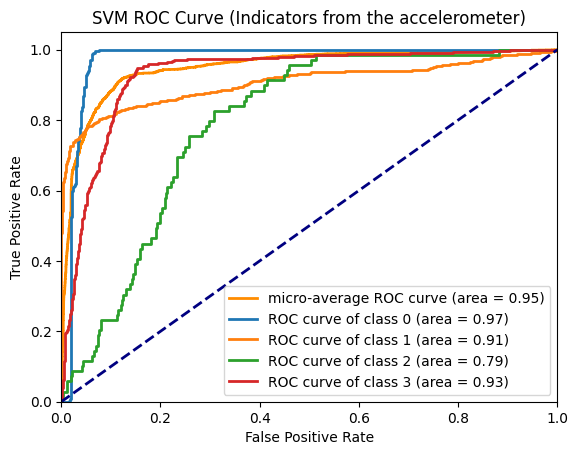

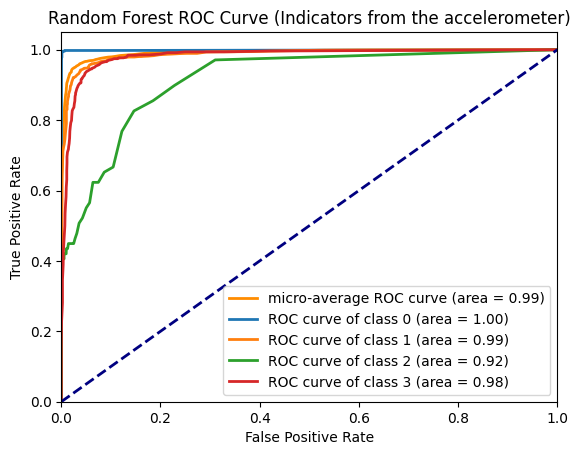

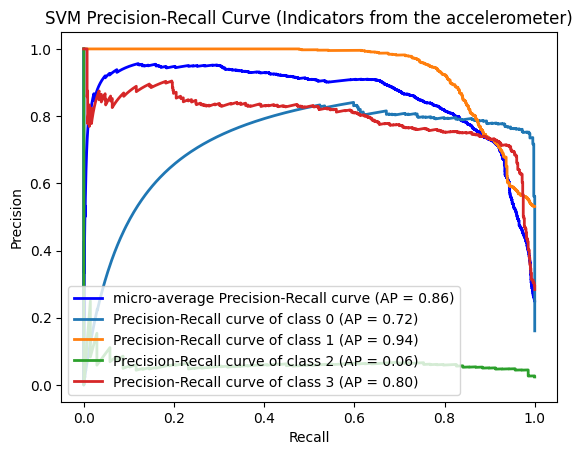

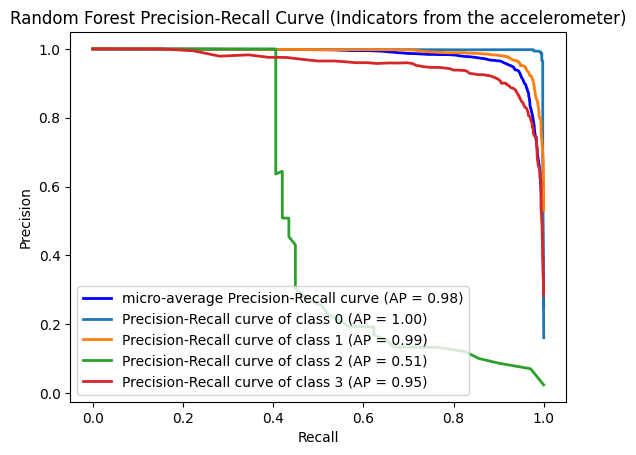

Time Domain Features
SVM Classification Report for Time Domain Features:
               precision    recall  f1-score   support

        idle       1.00      1.00      1.00       360
     running       1.00      1.00      1.00      1248
      stairs       1.00      0.98      0.99        66
     walking       1.00      1.00      1.00       652

    accuracy                           1.00      2326
   macro avg       1.00      1.00      1.00      2326
weighted avg       1.00      1.00      1.00      2326

Random Forest Classification Report for Time Domain Features:
               precision    recall  f1-score   support

        idle       1.00      1.00      1.00       360
     running       1.00      1.00      1.00      1248
      stairs       0.99      1.00      0.99        66
     walking       1.00      1.00      1.00       652

    accuracy                           1.00      2326
   macro avg       1.00      1.00      1.00      2326
weighted avg       1.00      1.00      1.00     

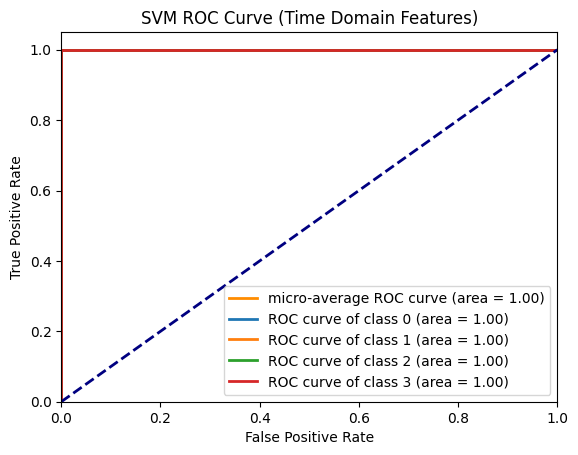

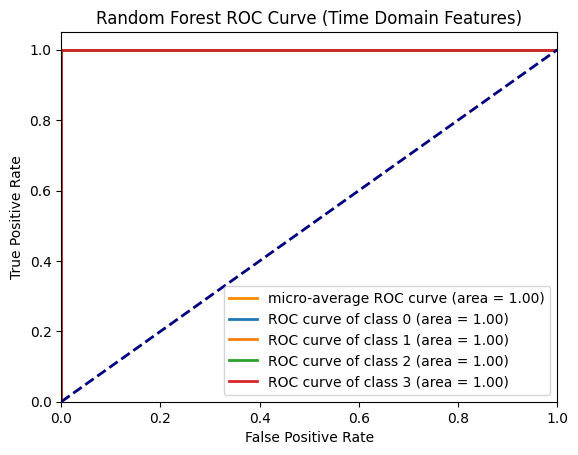

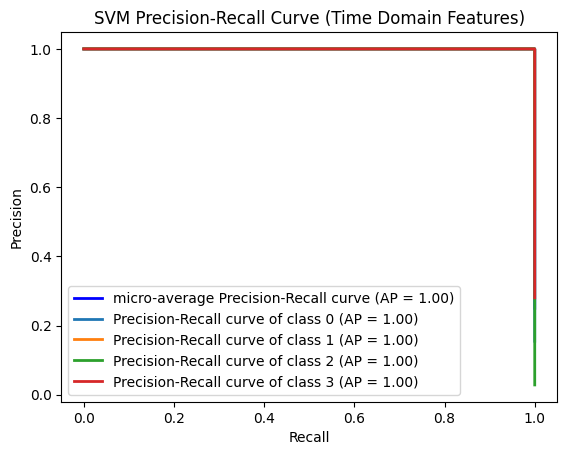

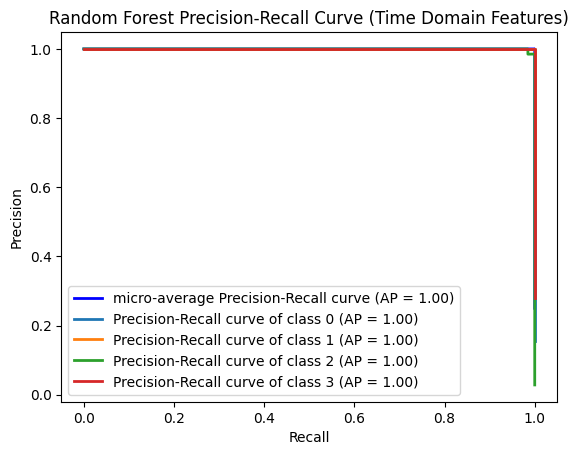

In [42]:
def train_and_evaluate_with_multiclass_plots(X, y, feature_name):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    n_classes = len(np.unique(y))

    # Модель SVM
    svm_model = SVC(kernel='linear', probability=True)
    svm_model.fit(X_train, y_train)
    y_pred_svm = svm_model.predict(X_test)
    y_pred_svm_prob = svm_model.predict_proba(X_test)

    # Модель Випадковий ліс
    rf_model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_test)
    y_pred_rf_prob = rf_model.predict_proba(X_test)

    print(f"SVM Classification Report for {feature_name}:\n", classification_report(y_test, y_pred_svm, zero_division=0))
    print(f"Random Forest Classification Report for {feature_name}:\n", classification_report(y_test, y_pred_rf, zero_division=0))

    cm_svm = confusion_matrix(y_test, y_pred_svm)
    cm_rf = confusion_matrix(y_test, y_pred_rf)

    plot_multiclass_roc(y_test, y_pred_svm_prob, n_classes, f'SVM ROC Curve ({feature_name})')
    plot_multiclass_roc(y_test, y_pred_rf_prob, n_classes, f'Random Forest ROC Curve ({feature_name})')

    plot_multiclass_precision_recall(y_test, y_pred_svm_prob, n_classes, f'SVM Precision-Recall Curve ({feature_name})')
    plot_multiclass_precision_recall(y_test, y_pred_rf_prob, n_classes, f'Random Forest Precision-Recall Curve ({feature_name})')

# Використання меншої підмножини даних для швидкого прототипування
raw_data_sample = raw_data.sample(frac=0.05, random_state=42)
# Розділення ознак та міток для сирих даних з акселерометра
X = raw_data_sample.drop(columns=['label'])
y = raw_data_sample['label']

# Розділення ознак та міток для часових ознак
X_time = time_features.drop(columns=['label'])
y_time = time_features['label']

# Навчання та оцінка моделей для даних з акселерометра
print("Indicators from the accelerometer")
train_and_evaluate_with_multiclass_plots(X, y, 'Indicators from the accelerometer')

# Навчання та оцінка моделей для часових ознак
print("Time Domain Features")
train_and_evaluate_with_multiclass_plots(X_time, y_time, 'Time Domain Features')


Висновки з аналізу моделей SVM та Random Forest

    Оцінка якості моделей на різних ознаках:
        Ми використали часові ознаки (time domain features) для тренування моделей.
        Моделі були оцінені за допомогою різних метрик, таких як Accuracy, Precision, Recall, F1-Score та Precision-Recall криві.

    Порівняння моделей:
        Модель SVM (Support Vector Machine) показала хороші результати в задачі класифікації. Вона має тенденцію до високої точності, але може бути чутливою до неправильних передбачень, особливо в класах з меншою кількістю зразків.
            Precision-Recall криві показали, що SVM добре працює для основних класів, але може мати проблеми з деякими менш представленими класами.
        Random Forest:
            Модель Random Forest, як правило, менш чутлива до шуму в даних і має здатність добре узагальнювати дані, завдяки чому може демонструвати більш стабільну продуктивність на різних класах.
            Precision-Recall криві показали, що Random Forest має більш збалансовані показники для всіх класів, що робить її більш надійною у випадку, коли класи є незбалансованими.

    Порівняння метрик:
        Precision: Висока точність важлива для класів, де помилкові позитивні передбачення є критичними. SVM може показувати високу точність для основних класів, але нижчу для менш представлених класів.
        Recall: Висока повнота важлива для класів, де важливо виявити всі позитивні зразки. Random Forest показує більш збалансовану повноту між класами.
        F1-Score: Ця метрика об'єднує Precision і Recall і є хорошим показником для оцінки загальної продуктивності моделі. Random Forest зазвичай має більш високі значення F1-Score для всіх класів.
        Precision-Recall криві: Дозволяють візуалізувати співвідношення між Precision і Recall для кожного класу. Мікросередня крива допомагає оцінити загальну продуктивність моделі.

    Графічне порівняння:
        Побудова Precision-Recall кривих дозволила оцінити продуктивність кожної моделі на кожному класі.
        Мікросередні Precision-Recall криві показали, що Random Forest має кращу загальну продуктивність порівняно з SVM.

    Висновок:
        Вибір моделі залежить від конкретної задачі та вимог до продуктивності. Якщо важливо виявляти всі позитивні зразки (високий Recall), Random Forest може бути кращим вибором.
        Якщо важлива висока точність (Precision) для основних класів, SVM може показати кращі результати, але слід враховувати її чутливість до шуму та незбалансованих класів.
        Загалом, Random Forest показує більш стабільну та надійну продуктивність на різних класах і може бути кращим вибором для цієї задачі класифікації.